In [1]:
from typing import Any, Dict  # noqa

import gym
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import pybulletgym

from ezrl.algorithms.ppo import PPOOptimizer
from ezrl.policy import ACPolicy

In [2]:
import torch.nn as nn
import torch.distributions as td

class AntACPolicy(ACPolicy):
    def __init__(self):
        super().__init__()
        self.input_dims = 28
        self.action_dims = 8

        self.policy_net = nn.Sequential(
            nn.Linear(28, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 8, bias=False)
        )

        self.critic_net = nn.Sequential(
            nn.Linear(28, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1, bias=False)
        )

        log_std = -0.5 * np.ones(self.action_dims, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))

    def log_prob(self, dist: td.Distribution, actions: torch.Tensor):
        if isinstance(dist, td.Categorical):
            return dist.log_prob(actions)
        return dist.log_prob(actions).sum(axis=-1)

    def forward(self, obs: Any) -> Dict[str, Any]:
        mu = self.policy_net(obs)
        std = torch.exp(self.log_std)
        dist = td.normal.Normal(mu, std)
        action = dist.sample()
        log_probs = self.log_prob(dist, action)
        value = self.critic_net(obs).squeeze()
        return {"action":action, "dist":dist, "log_probs":log_probs, "values":value}

    def critic(self, obs:Any):
        return self.critic_net(obs).squeeze()

    def act(self, obs: Any):
        out = self.forward(obs)
        return np.squeeze(out["action"].detach().cpu().numpy()), out

In [3]:
def ppo_rollout(
    policy: ACPolicy, env_name: str = None, env=None, env_creation_fn=None
) -> Dict[str, np.array]:
    if env_name is None and env is None:
        raise ValueError("env_name or env must be provided!")
    if env is None:
        if env_creation_fn is None:
            env_creation_fn = gym.make
        env = env_creation_fn(env_name)
    done = False
    observations, actions, rewards, log_probs, values = ([], [], [], [], [])
    observation = env.reset()
    with torch.no_grad():
        while not done:
            obs = torch.from_numpy(observation).to(policy.device)
            action, out = policy.act(obs)
            v = out["values"]
            next_observation, reward, done, info = env.step(action)

            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(out["log_probs"].detach().cpu().numpy())
            values.append(v.detach().cpu().numpy())

            observation = next_observation
    # env.close()
    return {
        "observations": np.array(observations),
        "actions": np.array(actions),
        "rewards": np.array(rewards),
        "log_probs": np.array(log_probs),
        "values": np.array(values),
    }

In [4]:
from ezrl.utils import get_tensorboard_logger

In [5]:
from tqdm import tqdm
import gym

bar = tqdm(np.arange(50000))

seed = 0

torch.manual_seed(seed)
np.random.seed(seed)


policy = AntACPolicy()
device = torch.device('cuda')
policy = policy.to(device)

env = gym.make("AntPyBulletEnv-v0")
optimizer = PPOOptimizer(policy, pi_lr=0.0005)
writer = get_tensorboard_logger("PPOOptimizer")

for i in bar:
    rollouts = optimizer.rollout(ppo_rollout, env=env)

    losses = []
    actor_losses = []
    value_losses = []
    rewards = []

    for r in rollouts:
        observations = torch.from_numpy(r["observations"]).float().to(policy.device)
        actions = torch.from_numpy(r["actions"]).float().to(policy.device)
        log_probs = torch.from_numpy(r["log_probs"]).float().to(policy.device)
        torch_rewards = torch.from_numpy(r["rewards"]).float().to(policy.device)
        torch_values = torch.from_numpy(r["values"]).float().to(policy.device)

        for _ in range(5): # train each episode for 5 iterations
            optimizer.zero_grad()
            loss, actor_loss, value_loss = optimizer.loss_fn(observations, actions, log_probs, torch_rewards, torch_values)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(policy.parameters(), 100.0)
            optimizer.step()

            grad_dict = {}
            for n, W in policy.named_parameters():
                if W.grad is not None:
                    grad_dict["{}_grad".format(n)] = float(torch.sum(W.grad).item())

        rewards.append(np.sum(r["rewards"]))
        losses.append(loss.item())
        actor_losses.append(actor_loss.item())
        value_losses.append(value_loss.item())

    metrics_dict = {"loss":np.mean(losses), "actor_loss":np.mean(actor_losses), "value_loss":np.mean(value_losses), "sum_reward":np.mean(rewards), **grad_dict}

    for key in metrics_dict:
        writer.add_scalar(key, metrics_dict[key], i)


    bar.set_description("Loss: {}, Reward: {}".format(loss, np.mean(rewards)))

  0%|          | 0/50000 [00:00<?, ?it/s]pybullet build time: Dec 23 2020 01:49:05


WalkerBase::__init__
Follow tensorboard logs with: tensorboard --logdir '/home/shyam/Code/ez-rl/examples/tensorboard_logs/PPOOptimizer_2022-05-21 01:41:01.574102'


Loss: 217.10606384277344, Reward: 854.6888279715931:   3%|▎         | 1591/50000 [46:16<23:28:11,  1.75s/it] 


KeyboardInterrupt: 

In [6]:
def ppo_rollout(
    policy: ACPolicy, env_name: str = None, env=None, env_creation_fn=None, render=True
) -> Dict[str, np.array]:
    if env_name is None and env is None:
        raise ValueError("env_name or env must be provided!")
    if env is None:
        if env_creation_fn is None:
            env_creation_fn = gym.make
        env = env_creation_fn(env_name)
    done = False
    observations, actions, rewards, log_probs, values = ([], [], [], [], [])
    rendereds = []
    observation = env.reset()
    with torch.no_grad():
        while not done:
            rendered = None
            if render:
                rendered = env.render(mode="rgb_array")
            rendereds.append(rendered)
            obs = torch.from_numpy(observation).to(policy.device)
            action, out = policy.act(obs)
            v = policy.critic(obs)
            next_observation, reward, done, info = env.step(action)

            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(out["log_probs"].detach().cpu().numpy())
            values.append(v.detach().cpu().numpy())

            observation = next_observation
    # env.close()
    return {
        "observations": np.array(observations),
        "actions": np.array(actions),
        "rewards": np.array(rewards),
        "log_probs": np.array(log_probs),
        "values": np.array(values),
        "renderds": rendereds
    }

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib ipympl

plt.style.use('ggplot')
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
from celluloid import Camera
from IPython.display import HTML


def render_rollout(policy):
    env = gym.make("AntPyBulletEnv-v0")
    fig = plt.figure("Animation",figsize=(7,5))
    camera = Camera(fig)
    ax = fig.add_subplot(111)
    out = ppo_rollout(policy=policy, env=env, render=True)
    renderds = np.array(out["renderds"])
    frames = []
    for r in renderds:
        frame = ax.imshow(r)
        ax.axis('off')
        camera.snap()
        frames.append([frame])
    animation = camera.animate(blit=False, interval=50)
    # display(animations.to_html5_video())
    animation.save('Ant.mp4')
    return animation


WalkerBase::__init__


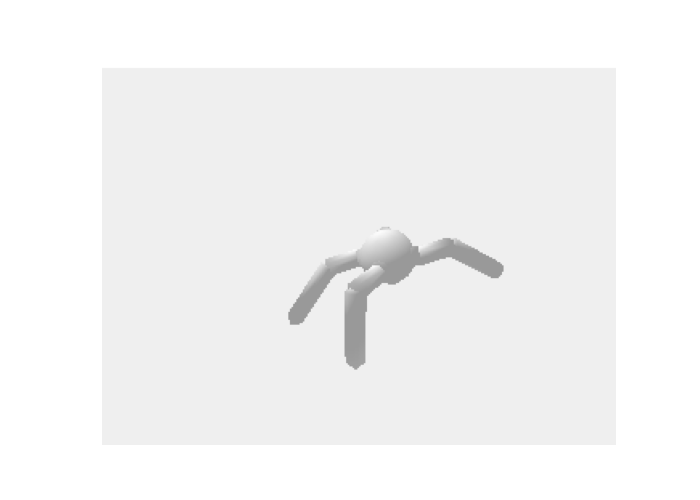

In [8]:
animation = render_rollout(policy)

In [10]:
from IPython.display import Video
Video("Ant.mp4")